# Import

In [1]:
import numpy as np
import pandas as pd
import timm
import random
import os
from PIL import Image
import torch

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import tqdm
from torch import nn
from torch import optim

# Set seed (Reproduce result)

In [2]:
SEED = 123456789

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Split data

In [3]:
data = pd.read_csv('cassava-leaf-disease-classification/train.csv')
choosen_prob = np.random.rand(len(data))
train_df = data[choosen_prob >= 0.2]
val_df = data[choosen_prob < 0.2]

In [4]:
len(val_df)

4294

In [5]:
len(train_df)

17103

# Hyper params

In [6]:
MODEL_NAME = 'tf_efficientnet_b3_ns'
IM_SIZE = 300
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCH = 50
NUM_WORKER = 8
WEIGHT_DECAY = 1e-4

# Data augmentation

In [7]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomResizedCrop((IM_SIZE, IM_SIZE)),
     transforms.RandomRotation(90),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((IM_SIZE, IM_SIZE)),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Dataset

In [8]:
class CassavaDataset(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        label = row.label
        image_name = row.image_id
        
        image = Image.open(os.path.join(self.image_dir, image_name))
        image = np.array(image)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [9]:
train_image_dir = 'cassava-leaf-disease-classification/train_images'
train_dataset = CassavaDataset(train_image_dir, train_df, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True, 
                                           num_workers=NUM_WORKER)

val_image_dir = 'cassava-leaf-disease-classification/train_images'
val_dataset = CassavaDataset(val_image_dir, val_df, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=False, 
                                           num_workers=NUM_WORKER)

# Model

In [10]:
device = torch.device("cuda")
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

model.cuda()
print('Convert model to CUDA')

# for param in model.parameters():
#     param.requires_grad = False

# model.classifier.train()
# model.conv_head.train()
# model.bn2.train()

Convert model to CUDA


# Train and Val

In [12]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    scaler = torch.cuda.amp.GradScaler()
    for i, data in enumerate(tqdm.tqdm(train_loader), 0):
        inputs, labels = data
        with torch.cuda.amp.autocast():
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            assert outputs.dtype is torch.float16
            loss = criterion(outputs, labels)
            assert loss.dtype is torch.float32
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        running_loss += loss.item()
        
    return running_loss / len(train_loader)

In [13]:
def validate(model, val_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm.tqdm(val_loader):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# def frezze_top(Model):
#     pass

In [14]:
train_loss_list = []
val_acc_list = []
for epoch in range(EPOCH):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
    val_acc = validate(model, val_loader)
    print("Accuracy at epoch {} is: {}".format(epoch, val_acc))
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)

  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 0 is: 0.7189101071262226


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 1 is: 0.7622263623660922


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 2 is: 0.7824871914299022


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 3 is: 0.7899394503959013


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 4 is: 0.7980903586399627


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 5 is: 0.8004191895668374


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 6 is: 0.8162552398695855


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 7 is: 0.8139264089427107


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 8 is: 0.8157894736842105


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 9 is: 0.8225430833721472


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 10 is: 0.8255705635770842


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 11 is: 0.8255705635770842


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 12 is: 0.8292966930600838


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 13 is: 0.8267349790405216


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 14 is: 0.8248719142990218


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 15 is: 0.8341872380065207


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 16 is: 0.8306939916162087


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 17 is: 0.8376804843968327


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 18 is: 0.8337214718211458


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 19 is: 0.8290638099673964


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 20 is: 0.827433628318584


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 21 is: 0.8372147182114579


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 22 is: 0.8402421984163949


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 23 is: 0.8430367955286446


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 24 is: 0.8395435491383325


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 25 is: 0.8425710293432697


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 26 is: 0.8379133674895203


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 27 is: 0.8367489520260829


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 28 is: 0.8362831858407079


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 29 is: 0.8383791336748952


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 30 is: 0.8386120167675827


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 31 is: 0.8404750815090825


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 32 is: 0.8374476013041453


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 33 is: 0.8393106660456451


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 34 is: 0.8411737307871449


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 35 is: 0.8390777829529577


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 36 is: 0.8388448998602701


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 37 is: 0.8388448998602701


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 38 is: 0.8367489520260829


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 39 is: 0.8409408476944574


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 40 is: 0.8379133674895203


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 41 is: 0.832324173265021


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 42 is: 0.8360503027480205


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 43 is: 0.8362831858407079


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 44 is: 0.8297624592454588


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 45 is: 0.8358174196553331


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 46 is: 0.8402421984163949


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 47 is: 0.8309268747088961


  0%|          | 0/535 [00:00<?, ?it/s]

Accuracy at epoch 48 is: 0.8341872380065207


100%|██████████| 135/135 [00:30<00:00,  4.42it/s]

Accuracy at epoch 49 is: 0.8353516534699581


# Visualize train loss and val loss

[0.8694132191555523, 0.5938268972891514, 0.5278292329790436, 0.4910869395342943, 0.4644577529246562, 0.45378980713191436, 0.437624522932222, 0.4200279466877474, 0.4084374508707323, 0.4031372965496277, 0.4034891744222596, 0.3951580969529731, 0.3804121862087294, 0.38130371995339885, 0.37355400655314186, 0.37652187914213286, 0.35736652786765144, 0.3560287195388402, 0.35480107923395166, 0.3501567721923935, 0.3367927601961332, 0.3403036223950787, 0.3250240072677626, 0.32439821659126017, 0.32000958487112946, 0.3157757048434186, 0.318619923836717, 0.3082002485745421, 0.3100166920119914, 0.293340590463899, 0.29711150635625716, 0.29112038457783584, 0.286175102294884, 0.28285730991547353, 0.2785466700653049, 0.2729925114974797, 0.26822056273155126, 0.2697971634775679, 0.2600906587023044, 0.25317008902675636, 0.25223034254022847, 0.24908736381575325, 0.24322366983255495, 0.24192839057715695, 0.23769758069348113, 0.22891482488713533, 0.2220919440735445, 0.22226789871526656, 0.22106617878530627, 0.

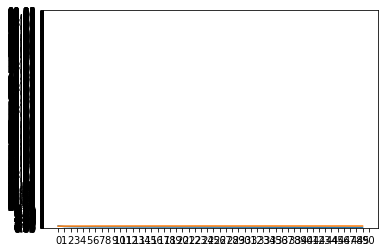

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_loss_list)
print(val_acc_list)

plt.plot(train_loss_list)
plt.plot(val_acc_list)

plt.xticks(np.arange(0, EPOCH + 1, 1))
plt.yticks(np.arange(0, 100, 0.05))
plt.show()